In [21]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from gurobipy import Model, GRB, quicksum, QuadExpr
from sklearn.datasets import fetch_california_housing
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)
df.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [14]:
# Vanilla MIQP-Model to hard-code any k (best k subest of features to select) for a regression problem

# -------------------------------
# Step 1: Prepare the data
# -------------------------------

# Input data
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

# Standardize X
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns).reset_index(drop=True)

# Standardize y
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Prepare variables
X_mat = X_scaled_df.values
y_vec = y_scaled
n, p = X_mat.shape

# -------------------------------
# Step 2: Gurobi MIP Setup
# -------------------------------
k = 4         # Max number of features to select
M = 50        # Big-M constant
start_time = time.time()

model = Model("L0_Feature_Selection")
model.setParam('OutputFlag', 0)  # Set to 1 to debug

# Variables
beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
z = model.addVars(p, vtype=GRB.BINARY, name="z")

# Objective: Minimize MSE using QuadExpr
mse_expr = QuadExpr()
for i in range(n):
    expr = quicksum(X_mat[i, j] * beta[j] for j in range(p))
    diff = y_vec[i] - expr
    mse_expr.add(diff * diff)
mse_expr /= n
model.setObjective(mse_expr, GRB.MINIMIZE)

# Constraints
for j in range(p):
    model.addConstr(beta[j] <=  M * z[j])
    model.addConstr(beta[j] >= -M * z[j])
model.addConstr(quicksum(z[j] for j in range(p)) <= k)

# Optimize
model.optimize()
end_time = time.time()

# -------------------------------
# Step 3: Extract solution
# -------------------------------
selected_features = [X_scaled_df.columns[j] for j in range(p) if z[j].X > 0.5]
selected_coeffs = [beta[j].X for j in range(p) if z[j].X > 0.5]

# Create full beta vector
beta_full = np.zeros(p)
for i, feature in enumerate(X_scaled_df.columns):
    if feature in selected_features:
        idx = selected_features.index(feature)
        beta_full[i] = selected_coeffs[idx]

# -------------------------------
# Step 4: Predict and evaluate
# -------------------------------
y_pred_scaled = X_mat @ beta_full
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_vec.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
compute_time = end_time - start_time

# -------------------------------
# Results
# -------------------------------
print("Selected features:", selected_features)
print("Coefficients:", selected_coeffs)
print("MSE:", mse)
print("R²:", r2)
print(f"Total time taken by vanilla MIP without Whitening (k={k}): {compute_time:.2f} seconds")


Set parameter Username
Set parameter LicenseID to value 2676945
Academic license - for non-commercial use only - expires 2026-06-10
Selected features: ['MedInc', 'HouseAge', 'Latitude', 'Longitude']
Coefficients: [0.6231185488472172, 0.10416727006115976, -0.8202436895326117, -0.7836898520864357]
MSE: 0.540576060099744
R²: 0.5940250548052655
Total time taken by vanilla MIP without Whitening (k=4): 6.39 seconds


k= 1 | R²=0.4734 | MSE=0.7011 | Time=4.41s
k= 2 | R²=0.5091 | MSE=0.6536 | Time=4.27s
k= 3 | R²=0.5843 | MSE=0.5536 | Time=4.20s
k= 4 | R²=0.5940 | MSE=0.5406 | Time=4.18s
k= 5 | R²=0.5988 | MSE=0.5342 | Time=4.52s
k= 6 | R²=0.6050 | MSE=0.5259 | Time=4.11s
k= 7 | R²=0.6062 | MSE=0.5243 | Time=4.30s
k= 8 | R²=0.6062 | MSE=0.5243 | Time=3.96s


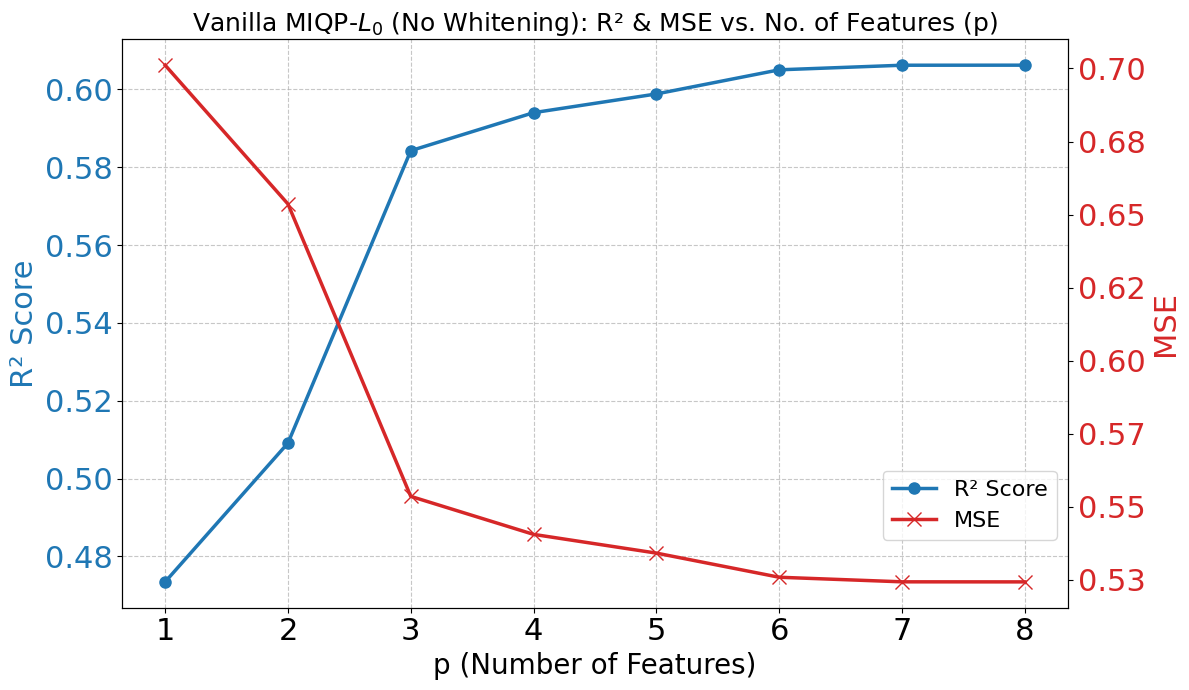

In [65]:
# Extending our hard-coded version of Vanilla MIQP to loop over different k values and plotting evolution of R² and MSE
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from gurobipy import Model, GRB, quicksum, QuadExpr

# -------------------------------
# Step 1: Prepare the data
# -------------------------------
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

# Standardize X
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns).reset_index(drop=True)

# Standardize y
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Matrix setup
X_mat = X_scaled_df.values
y_vec = y_scaled
y_true = scaler_y.inverse_transform(y_vec.reshape(-1, 1)).flatten()
n, p = X_mat.shape

# -------------------------------
# Step 2: Loop over different k
# -------------------------------
r2_scores = []
mse_scores = []
k_values = range(1, p + 1)
M = 50  # Big-M constant

for k in k_values:
    start_time = time.time()
    model = Model(f"MIP_R2_MSE_k{k}")
    model.setParam('OutputFlag', 0)

    # Variables
    beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
    z = model.addVars(p, vtype=GRB.BINARY, name="z")

    # Objective: Minimize MSE
    mse_expr = QuadExpr()
    for i in range(n):
        expr = quicksum(X_mat[i, j] * beta[j] for j in range(p))
        diff = y_vec[i] - expr
        mse_expr.add(diff * diff)
    mse_expr /= n
    model.setObjective(mse_expr, GRB.MINIMIZE)

    # Constraints
    for j in range(p):
        model.addConstr(beta[j] <= M * z[j])
        model.addConstr(beta[j] >= -M * z[j])
    model.addConstr(quicksum(z[j] for j in range(p)) <= k)

    # Optimize
    model.optimize()
    end_time = time.time()

    # Coefficient extraction
    beta_full = np.array([beta[j].X if z[j].X > 0.5 else 0 for j in range(p)])
    y_pred_scaled = X_mat @ beta_full
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Compute metrics
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2_scores.append(r2)
    mse_scores.append(mse)

    print(f"k={k:2d} | R²={r2:.4f} | MSE={mse:.4f} | Time={end_time - start_time:.2f}s")

# -------------------------------
# Dual-Axis Plot: R² and MSE vs. k
# -------------------------------
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 7))

# Set font sizes
label_fontsize = 22
tick_fontsize = 22
title_fontsize = 18
axis_Label_fontsize = 20

# Left axis: R²
color = 'tab:blue'
ax1.set_xlabel('p (Number of Features)', fontsize=axis_Label_fontsize)
ax1.set_ylabel('R² Score', color=color, fontsize=label_fontsize)
r2_line, = ax1.plot(
    k_values, r2_scores,
    color=color, marker='o', markersize=8, linewidth=2.5,
    label='R² Score'
)
ax1.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

# Right axis: MSE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MSE', color=color, fontsize=label_fontsize)
mse_line, = ax2.plot(
    k_values, mse_scores,
    color=color, marker='x', markersize=10, linewidth=2.5,
    label='MSE'
)
ax2.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)

# Format MSE y-axis ticks to 2 decimal places
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.title(
    'Vanilla MIQP-$L_{0}$ (No Whitening): R² & MSE vs. No. of Features (p)',
    fontsize=title_fontsize
)

# ✅ Combine handles and add legend in lower right
lines = [r2_line, mse_line]
labels = [line.get_label() for line in lines]

ax1.legend(
    lines, labels,
    loc='lower right',
    bbox_to_anchor=(1, 0.10),
    fontsize=16,
    frameon=True
)

fig.tight_layout()
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

plt.show()






✅ Bisection complete.
Best k found: 6
Best R²: 0.605
Unique k values evaluated during bisection: [3, 4, 5, 6, 7]
Total MIP evaluations during bisection: 5
k= 1 | R²=0.4734 | MSE=0.7011
k= 2 | R²=0.5091 | MSE=0.6536
k= 3 | R²=0.5843 | MSE=0.5536
k= 4 | R²=0.5940 | MSE=0.5406
k= 5 | R²=0.5988 | MSE=0.5342
k= 6 | R²=0.6050 | MSE=0.5259
k= 7 | R²=0.6062 | MSE=0.5243
k= 8 | R²=0.6062 | MSE=0.5243


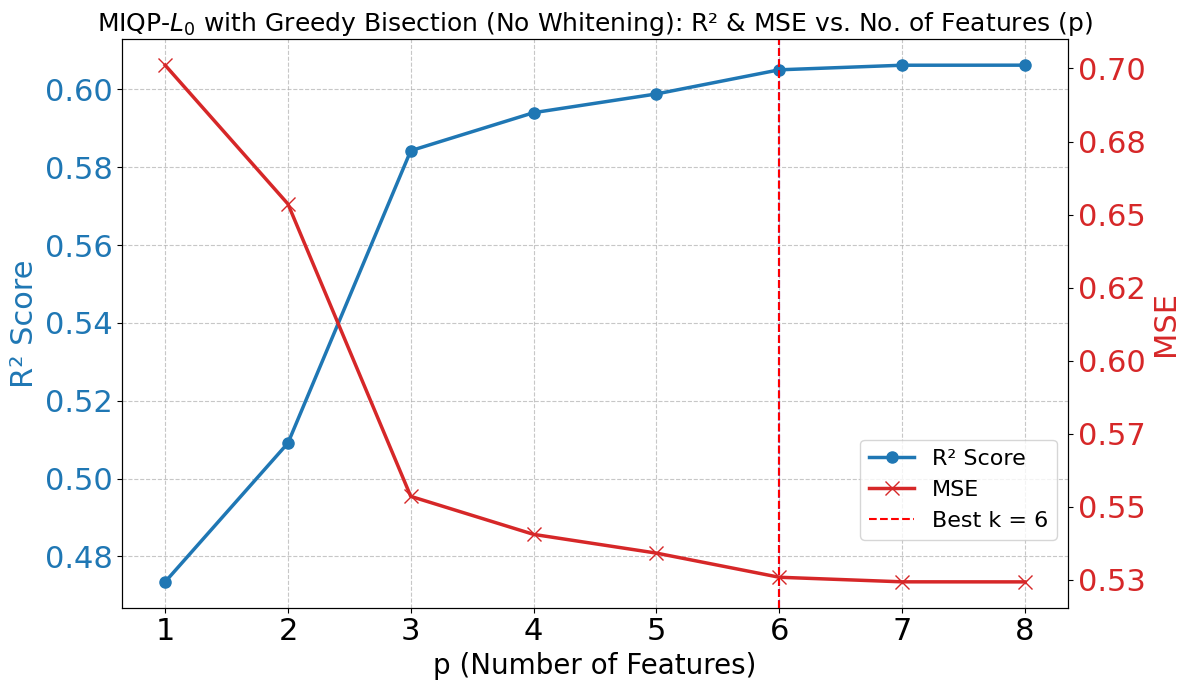

In [ ]:
# Extending the looped over Vanilla MIQP to implement a bisection method with feelers to find the best k value

# -------------------------------
# Step 1: Prepare the data
# -------------------------------
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

# Standardize X
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns).reset_index(drop=True)

# Standardize y
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Setup matrices
X_mat = X_scaled_df.values
y_vec = y_scaled
y_true = scaler_y.inverse_transform(y_vec.reshape(-1, 1)).flatten()
n, p = X_mat.shape

# -------------------------------
# Step 2: Bisection with Feelers
# -------------------------------

evaluated_ks = {}
bisection_eval_count = 0
track_bisection = True
M = 50  # Big-M constant

def evaluate_k(k):
    global bisection_eval_count
    if k in evaluated_ks:
        return evaluated_ks[k]
    
    if track_bisection:
        bisection_eval_count += 1

    model = Model(f"MIP_k{k}")
    model.setParam('OutputFlag', 0)

    # Variables
    beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
    z = model.addVars(p, vtype=GRB.BINARY, name="z")

    # Objective
    mse_expr = QuadExpr()
    for i in range(n):
        expr = quicksum(X_mat[i, j] * beta[j] for j in range(p))
        diff = y_vec[i] - expr
        mse_expr.add(diff * diff)
    mse_expr /= n
    model.setObjective(mse_expr, GRB.MINIMIZE)

    # Constraints
    for j in range(p):
        model.addConstr(beta[j] <= M * z[j])
        model.addConstr(beta[j] >= -M * z[j])
    model.addConstr(quicksum(z[j] for j in range(p)) <= k)

    model.optimize()

    beta_vals = np.array([beta[j].X if z[j].X > 0.5 else 0 for j in range(p)])
    y_pred_scaled = X_mat @ beta_vals
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    evaluated_ks[k] = (r2, mse)
    return r2, mse

# -------------------------------
# Step 3: Perform Bisection
# -------------------------------
k_low, k_high = 1, p
best_k = None
best_r2 = -np.inf
feelers = 1

while k_high - k_low > 2:
    k_mid = (k_low + k_high) // 2
    r2_mid, _ = evaluate_k(k_mid)
    r2_left, _ = evaluate_k(k_mid - feelers)
    r2_right, _ = evaluate_k(k_mid + feelers)

    if r2_mid > best_r2:
        best_r2 = r2_mid
        best_k = k_mid

    if r2_left > r2_right:
        k_high = k_mid
    else:
        k_low = k_mid

print("✅ Bisection complete.")
print("Best k found:", best_k)
print("Best R²:", round(best_r2, 4))
print("Unique k values evaluated during bisection:", sorted(evaluated_ks.keys()))
print("Total MIP evaluations during bisection:", bisection_eval_count)

# -------------------------------
# Step 4: Full Evaluation for Plot
# -------------------------------
track_bisection = False
r2_scores = []
mse_scores = []
k_values = range(1, p + 1)

for k in k_values:
    r2, mse = evaluate_k(k)
    r2_scores.append(r2)
    mse_scores.append(mse)
    print(f"k={k:2d} | R²={r2:.4f} | MSE={mse:.4f}")

# -------------------------------
# Step 5: Dual-Axis Plot: R² and MSE vs. k
# -------------------------------
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax1 = plt.subplots(figsize=(12, 7))  # Consistent size

# Font sizes
label_fontsize = 22
tick_fontsize = 22
title_fontsize = 18
axis_Label_fontsize = 20

# Left axis: R²
color = 'tab:blue'
ax1.set_xlabel('p (Number of Features)', fontsize=axis_Label_fontsize)
ax1.set_ylabel('R² Score', color=color, fontsize=label_fontsize)
r2_line, = ax1.plot(
    k_values, r2_scores,
    color=color, marker='o', markersize=8, linewidth=2.5, label='R² Score'
)
ax1.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

# Vertical line for best_k on left axis (blue, not used in legend)
ax1.axvline(best_k, color='blue', linestyle='--')

# Right axis: MSE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MSE', color=color, fontsize=label_fontsize)
mse_line, = ax2.plot(
    k_values, mse_scores,
    color=color, marker='x', markersize=10, linewidth=2.5, label='MSE'
)
ax2.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)

# Vertical line for best_k on right axis (red — this will go in the legend)
best_k_line = ax2.axvline(best_k, color='red', linestyle='--', label=f'Best p = {best_k}')

# Format MSE y-axis ticks to 2 decimal places
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.title(
    'MIQP-$L_{0}$ with Greedy Bisection (No Whitening): R² & MSE vs. No. of Features (p)',
    fontsize=title_fontsize
)

# ✅ Combine handles: R², MSE, and the red best_k line
lines = [r2_line, mse_line, best_k_line]
labels = [line.get_label() for line in lines]

# ✅ Legend in lower right, shifted upward by ~5% of figure height
ax1.legend(
    lines, labels,
    loc='lower right',
    bbox_to_anchor=(1, 0.10),  # (x, y) — decrease y to lower, increase y to raise
    fontsize=16,
    frameon=True
)

fig.tight_layout()
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

plt.show()


In [17]:
# MIQP-Model with ZCA whitening to hard-code any k (best k subest of features to select) for a regression problem

# -------------------------------
# Step 1: Prepare the data
# -------------------------------

def zca_whitening(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5  # For numerical stability
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return X_centered @ ZCA_matrix

# Input data
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

# Standardize X
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# ZCA Whitening
X_zca = zca_whitening(X_scaled)
X_zca = pd.DataFrame(X_zca, columns=X.columns).reset_index(drop=True)

# Standardize y
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Prepare variables
X_scaled = X_zca
y = y.reset_index(drop=True)
X_mat = X_scaled.values
y_vec = y_scaled
n, p = X_mat.shape

# -------------------------------
# Step 2: Gurobi MIP Setup
# -------------------------------
k = 4         # Max number of features to select
M = 50        # Big-M constant
start_time = time.time()

model = Model("L0_Feature_Selection")
model.setParam('OutputFlag', 0)  # Set to 1 to debug

# Variables
beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
z = model.addVars(p, vtype=GRB.BINARY, name="z")

# Objective: Minimize MSE using QuadExpr
mse_expr = QuadExpr()
for i in range(n):
    expr = quicksum(X_mat[i, j] * beta[j] for j in range(p))
    diff = y_vec[i] - expr
    mse_expr.add(diff * diff)
mse_expr /= n
model.setObjective(mse_expr, GRB.MINIMIZE)

# Constraints
for j in range(p):
    model.addConstr(beta[j] <=  M * z[j])
    model.addConstr(beta[j] >= -M * z[j])
model.addConstr(quicksum(z[j] for j in range(p)) <= k)

# Optimize
model.optimize()
end_time = time.time()

# -------------------------------
# Step 3: Extract solution
# -------------------------------
selected_features = [X_scaled.columns[j] for j in range(p) if z[j].X > 0.5]
selected_coeffs = [beta[j].X for j in range(p) if z[j].X > 0.5]

# Create full beta vector
beta_full = np.zeros(p)
for i, feature in enumerate(X_scaled.columns):
    if feature in selected_features:
        idx = selected_features.index(feature)
        beta_full[i] = selected_coeffs[idx]

# -------------------------------
# Step 4: Predict and evaluate
# -------------------------------
y_pred_scaled = X_scaled.values @ beta_full
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Inverse-transform the true target as well
y_true = scaler_y.inverse_transform(y_vec.reshape(-1, 1)).flatten()

# Evaluate using true values
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
compute_time = end_time - start_time

print("Selected features:", selected_features)
print("Coefficients:", selected_coeffs)
print("MSE:", mse)
print("R²:", r2)
print(f"Total time taken by vanilla MIP with ZCA whitening (k={k}): {compute_time:.2f} seconds")


Selected features: ['MedInc', 'HouseAge', 'Latitude', 'Longitude']
Coefficients: [0.6880727591050328, 0.13129738835681606, -0.26699369728101763, -0.20473516543562556]
MSE: 0.527510606352689
R²: 0.6038372667406707
Total time taken by vanilla MIP with ZCA whitening (k=4): 4.72 seconds


k= 1 | R²=0.4734 | MSE=0.7012 | Time=5.89s
k= 2 | R²=0.5447 | MSE=0.6063 | Time=5.10s
k= 3 | R²=0.5866 | MSE=0.5505 | Time=5.79s
k= 4 | R²=0.6038 | MSE=0.5275 | Time=5.47s
k= 5 | R²=0.6051 | MSE=0.5258 | Time=5.04s
k= 6 | R²=0.6060 | MSE=0.5246 | Time=4.08s
k= 7 | R²=0.6062 | MSE=0.5244 | Time=3.53s
k= 8 | R²=0.6062 | MSE=0.5243 | Time=3.91s


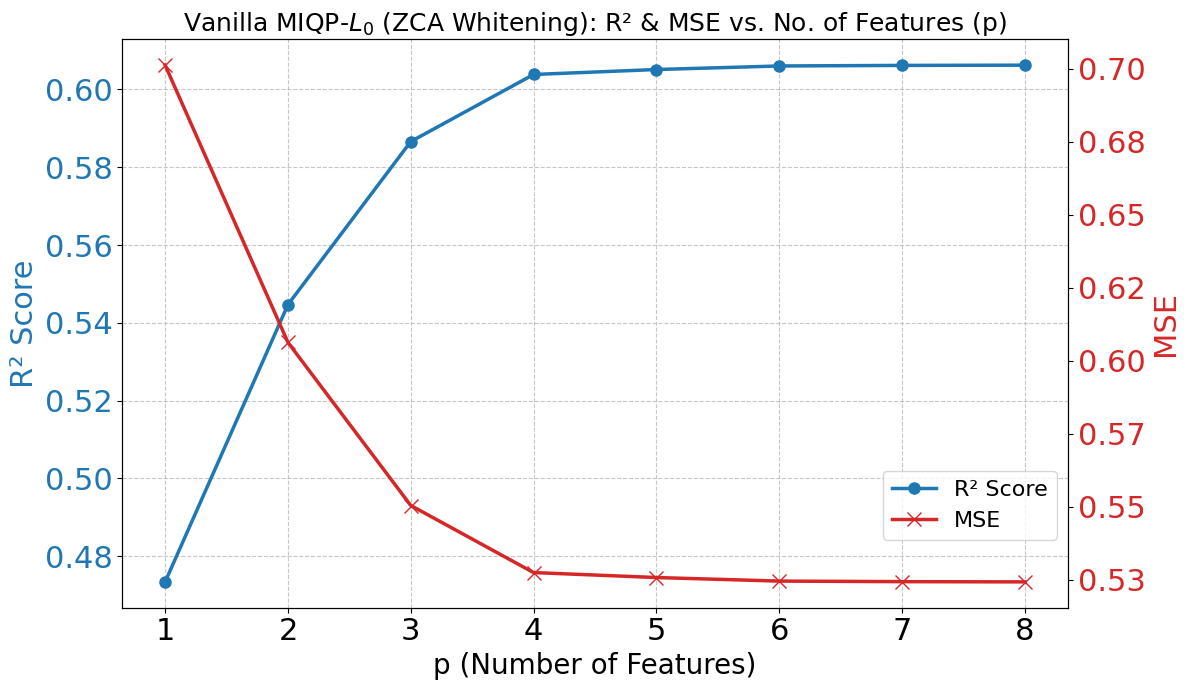

In [68]:
# Extending our hard-coded version of MIQP with ZCA whitening to loop over different k values and plotting evolution of R² and MSE

# -------------------------------
# Step 1: ZCA Whitening Function
# -------------------------------
def zca_whitening(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5  # for numerical stability
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return X_centered @ ZCA_matrix

# -------------------------------
# Step 2: Prepare the data
# -------------------------------
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

# Standardize X
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# ZCA whitening
X_zca = zca_whitening(X_scaled)
X_zca_df = pd.DataFrame(X_zca, columns=X.columns).reset_index(drop=True)

# Standardize y
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Matrix setup
X_mat = X_zca_df.values
y_vec = y_scaled
y_true = scaler_y.inverse_transform(y_vec.reshape(-1, 1)).flatten()
n, p = X_mat.shape

# -------------------------------
# Step 3: Loop over different k
# -------------------------------
r2_scores = []
mse_scores = []
k_values = range(1, p + 1)
M = 50  # Big-M constant

for k in k_values:
    start_time = time.time()
    model = Model(f"ZCA_MIP_k{k}")
    model.setParam('OutputFlag', 0)

    # Variables
    beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
    z = model.addVars(p, vtype=GRB.BINARY, name="z")

    # Objective
    mse_expr = QuadExpr()
    for i in range(n):
        expr = quicksum(X_mat[i, j] * beta[j] for j in range(p))
        diff = y_vec[i] - expr
        mse_expr.add(diff * diff)
    mse_expr /= n
    model.setObjective(mse_expr, GRB.MINIMIZE)

    # Constraints
    for j in range(p):
        model.addConstr(beta[j] <= M * z[j])
        model.addConstr(beta[j] >= -M * z[j])
    model.addConstr(quicksum(z[j] for j in range(p)) <= k)

    # Optimize
    model.optimize()
    end_time = time.time()

    # Prediction
    beta_full = np.array([beta[j].X if z[j].X > 0.5 else 0 for j in range(p)])
    y_pred_scaled = X_mat @ beta_full
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Evaluation
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2_scores.append(r2)
    mse_scores.append(mse)

    print(f"k={k:2d} | R²={r2:.4f} | MSE={mse:.4f} | Time={end_time - start_time:.2f}s")

# -------------------------------
# Step 4: Dual-Axis Plot
# -------------------------------
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 7))

# Set font sizes
label_fontsize = 22
tick_fontsize = 22
title_fontsize = 18
axis_Label_fontsize = 20

# Left axis: R²
color = 'tab:blue'
ax1.set_xlabel('p (Number of Features)', fontsize=axis_Label_fontsize)
ax1.set_ylabel('R² Score', color=color, fontsize=label_fontsize)
r2_line, = ax1.plot(
    k_values, r2_scores,
    color=color, marker='o', markersize=8, linewidth=2.5,
    label='R² Score'
)
ax1.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

# Right axis: MSE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MSE', color=color, fontsize=label_fontsize)
mse_line, = ax2.plot(
    k_values, mse_scores,
    color=color, marker='x', markersize=10, linewidth=2.5,
    label='MSE'
)
ax2.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)

# Format MSE y-axis ticks to 2 decimal places
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.title(
    'Vanilla MIQP-$L_{0}$ (ZCA Whitening): R² & MSE vs. No. of Features (p)',
    fontsize=title_fontsize
)

# ✅ Combine handles and add legend in lower right
lines = [r2_line, mse_line]
labels = [line.get_label() for line in lines]

ax1.legend(
    lines, labels,
    loc='lower right',
    bbox_to_anchor=(1, 0.10),
    fontsize=16,
    frameon=True
)

fig.tight_layout()
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

plt.show()



✅ Bisection complete.
Best k found: 6
Best R²: 0.606
Unique k values evaluated during bisection: [3, 4, 5, 6, 7]
Total MIP evaluations during bisection: 5
k= 1 | R²=0.4734 | MSE=0.7012
k= 2 | R²=0.5447 | MSE=0.6063
k= 3 | R²=0.5866 | MSE=0.5505
k= 4 | R²=0.6038 | MSE=0.5275
k= 5 | R²=0.6051 | MSE=0.5258
k= 6 | R²=0.6060 | MSE=0.5246
k= 7 | R²=0.6062 | MSE=0.5244
k= 8 | R²=0.6062 | MSE=0.5243


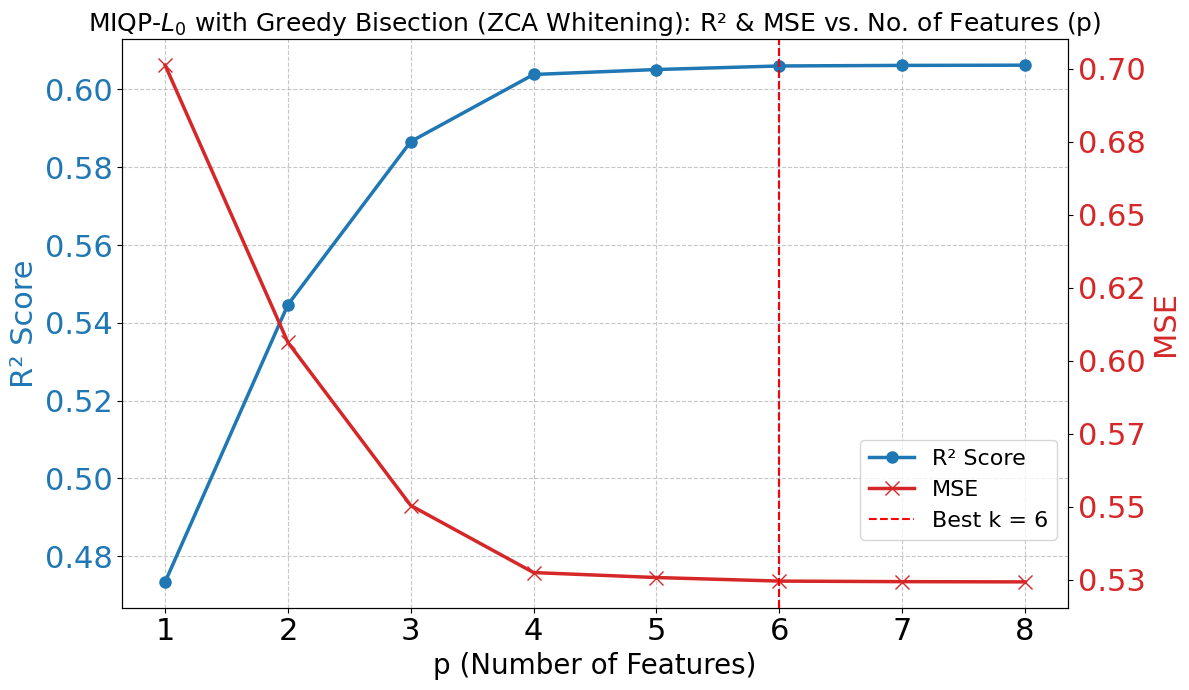

In [ ]:
# Extending our looped over MIQP with ZCA whitening to implement a bisection method with feelers to find the best k value
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from gurobipy import Model, GRB, quicksum, QuadExpr

# -------------------------------
# Step 1: ZCA Whitening Function
# -------------------------------
def zca_whitening(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return X_centered @ ZCA_matrix

# -------------------------------
# Step 2: Prepare the data
# -------------------------------
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_zca = zca_whitening(X_scaled)
X_zca_df = pd.DataFrame(X_zca, columns=X.columns).reset_index(drop=True)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

X_mat = X_zca_df.values
y_vec = y_scaled
y_true = scaler_y.inverse_transform(y_vec.reshape(-1, 1)).flatten()
n, p = X_mat.shape

# -------------------------------
# Step 3: Bisection Setup
# -------------------------------
evaluated_ks = {}
bisection_eval_count = 0
track_bisection = True
M = 50

def evaluate_k(k):
    global bisection_eval_count
    if k in evaluated_ks:
        return evaluated_ks[k]
    
    if track_bisection:
        bisection_eval_count += 1

    model = Model(f"ZCA_MIP_k{k}")
    model.setParam('OutputFlag', 0)

    beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
    z = model.addVars(p, vtype=GRB.BINARY, name="z")

    mse_expr = QuadExpr()
    for i in range(n):
        expr = quicksum(X_mat[i, j] * beta[j] for j in range(p))
        diff = y_vec[i] - expr
        mse_expr.add(diff * diff)
    mse_expr /= n
    model.setObjective(mse_expr, GRB.MINIMIZE)

    for j in range(p):
        model.addConstr(beta[j] <= M * z[j])
        model.addConstr(beta[j] >= -M * z[j])
    model.addConstr(quicksum(z[j] for j in range(p)) <= k)

    model.optimize()

    beta_vals = np.array([beta[j].X if z[j].X > 0.5 else 0 for j in range(p)])
    y_pred_scaled = X_mat @ beta_vals
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    evaluated_ks[k] = (r2, mse)
    return r2, mse

# -------------------------------
# Step 4: Bisection with Feelers
# -------------------------------
k_low, k_high = 1, p
best_k = None
best_r2 = -np.inf
feelers = 1

while k_high - k_low > 2:
    k_mid = (k_low + k_high) // 2
    r2_mid, _ = evaluate_k(k_mid)
    r2_left, _ = evaluate_k(k_mid - feelers)
    r2_right, _ = evaluate_k(k_mid + feelers)

    if r2_mid > best_r2:
        best_r2 = r2_mid
        best_k = k_mid

    if r2_left > r2_right:
        k_high = k_mid
    else:
        k_low = k_mid

print("✅ Bisection complete.")
print("Best k found:", best_k)
print("Best R²:", round(best_r2, 4))
print("Unique k values evaluated during bisection:", sorted(evaluated_ks.keys()))
print("Total MIP evaluations during bisection:", bisection_eval_count)

# -------------------------------
# Step 5: Full Evaluation for Plot
# -------------------------------
track_bisection = False
r2_scores = []
mse_scores = []
k_values = range(1, p + 1)

for k in k_values:
    r2, mse = evaluate_k(k)
    r2_scores.append(r2)
    mse_scores.append(mse)
    print(f"k={k:2d} | R²={r2:.4f} | MSE={mse:.4f}")

# -------------------------------
# Step 6: Dual-Axis Plot
# -------------------------------
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax1 = plt.subplots(figsize=(12, 7))  # Consistent size

# Font sizes
label_fontsize = 22
tick_fontsize = 22
title_fontsize = 18
axis_Label_fontsize = 20

# Left axis: R²
color = 'tab:blue'
ax1.set_xlabel('p (Number of Features)', fontsize=axis_Label_fontsize)
ax1.set_ylabel('R² Score', color=color, fontsize=label_fontsize)
r2_line, = ax1.plot(
    k_values, r2_scores,
    color=color, marker='o', markersize=8, linewidth=2.5, label='R² Score'
)
ax1.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

# Vertical line for best_k on left axis (blue, not used in legend)
ax1.axvline(best_k, color='blue', linestyle='--')

# Right axis: MSE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MSE', color=color, fontsize=label_fontsize)
mse_line, = ax2.plot(
    k_values, mse_scores,
    color=color, marker='x', markersize=10, linewidth=2.5, label='MSE'
)
ax2.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)

# Vertical line for best_k on right axis (red — this will go in the legend)
best_k_line = ax2.axvline(best_k, color='red', linestyle='--', label=f'Best p = {best_k}')

# Format MSE y-axis ticks to 2 decimal places
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.title(
    'MIQP-$L_{0}$ with Greedy Bisection (ZCA Whitening): R² & MSE vs. No. of Features (p)',
    fontsize=title_fontsize
)

# ✅ Combine handles: R², MSE, and the red best_k line
lines = [r2_line, mse_line, best_k_line]
labels = [line.get_label() for line in lines]

# ✅ Legend in lower right, shifted upward by ~5% of figure height
ax1.legend(
    lines, labels,
    loc='lower right',
    bbox_to_anchor=(1, 0.10),  # (x, y) — decrease y to lower, increase y to raise
    fontsize=16,
    frameon=True
)

fig.tight_layout()
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

plt.show()


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Fit OLS model using all standardized features
ols_model = LinearRegression()
ols_model.fit(X_scaled, y)

# Predict using the full model
y_pred_ols = ols_model.predict(X_scaled)

# Compute metrics
ols_mse = mean_squared_error(y, y_pred_ols)
ols_r2 = r2_score(y, y_pred_ols)

print("📊 OLS Baseline (All Features)")
print("OLS MSE:", round(ols_mse, 4))
print("OLS R²:", round(ols_r2, 4))


📊 OLS Baseline (All Features)
OLS MSE: 0.5243
OLS R²: 0.6062


📊 LASSO (No Whitening)
Selected features: 8
MSE: 0.5247
R²: 0.6059
Optimal alpha: 0.002253
      Feature  Coefficient  Selected
0      MedInc     0.707292      True
1    HouseAge     0.104981      True
2    AveRooms    -0.199388      True
3   AveBedrms     0.234237      True
4  Population    -0.000858      True
5    AveOccup    -0.032010      True
6    Latitude    -0.755521      True
7   Longitude    -0.728677      True


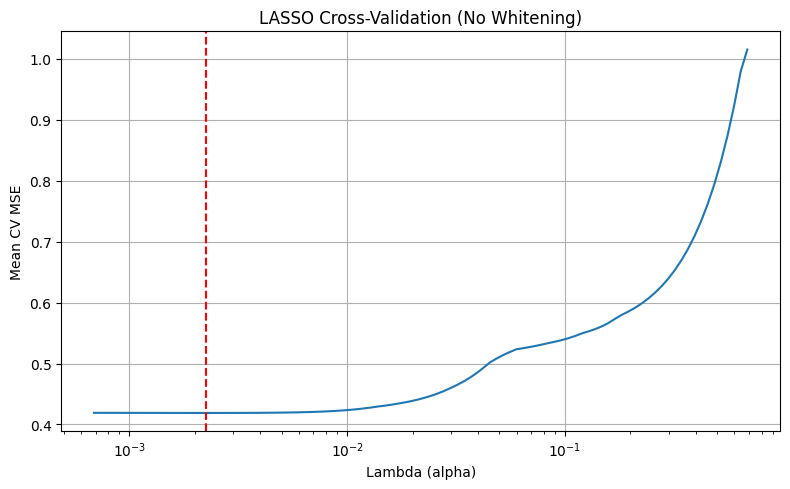

In [13]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------
# Standardize X and y (No Whitening)
# -------------------------------
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# -------------------------------
# Fit LASSO with CV
# -------------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y_scaled)

# Predict and transform back
y_pred_scaled = lasso.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluation
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("📊 LASSO (No Whitening)")
print("Selected features:", np.sum(lasso.coef_ != 0))
print("MSE:", round(mse, 4))
print("R²:", round(r2, 4))
print("Optimal alpha:", round(lasso.alpha_, 6))

# Summary table
feature_names = X.columns
lasso_summary = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso.coef_,
    'Selected': lasso.coef_ != 0
})
print(lasso_summary[lasso_summary['Selected']])

# Plot CV MSE vs alpha
plt.figure(figsize=(8, 5))
plt.semilogx(lasso.alphas_, lasso.mse_path_.mean(axis=1))
plt.axvline(lasso.alpha_, color='red', linestyle='--')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Mean CV MSE')
plt.title('LASSO Cross-Validation (No Whitening)')
plt.grid(True)
plt.tight_layout()
plt.show()


📊 LASSO (With ZCA Whitening)
Selected features: 6
MSE: 0.5259
R²: 0.605
Optimal alpha: 0.012892
     Feature  Coefficient  Selected
0     MedInc     0.675179      True
1   HouseAge     0.118404      True
2   AveRooms     0.022836      True
5   AveOccup    -0.017329      True
6   Latitude    -0.254099      True
7  Longitude    -0.191841      True


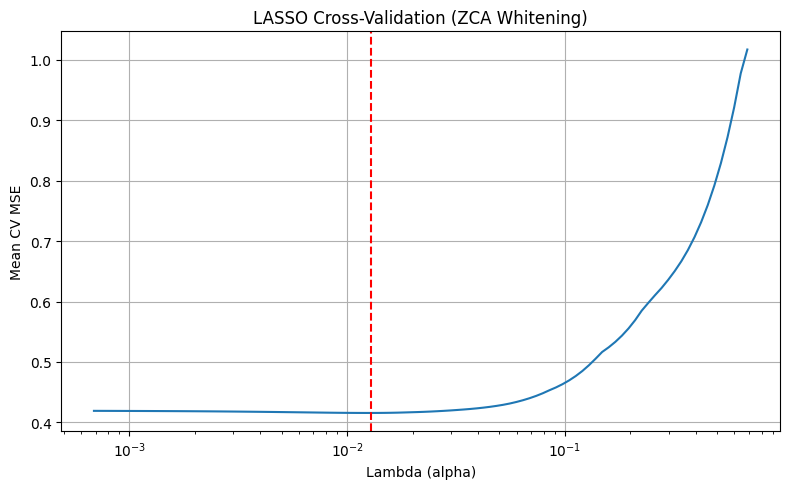

In [14]:
# -------------------------------
# ZCA Whitening Function
# -------------------------------
def zca_whitening(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return X_centered @ ZCA_matrix

# -------------------------------
# Prepare X and y
# -------------------------------
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_zca = zca_whitening(X_scaled)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# -------------------------------
# Fit LASSO with CV (Whitened X)
# -------------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_zca, y_scaled)

# Predict and inverse transform
y_pred_scaled = lasso.predict(X_zca)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluation
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("📊 LASSO (With ZCA Whitening)")
print("Selected features:", np.sum(lasso.coef_ != 0))
print("MSE:", round(mse, 4))
print("R²:", round(r2, 4))
print("Optimal alpha:", round(lasso.alpha_, 6))

# Summary table (note: interpretation of coefficients less direct)
feature_names = X.columns
lasso_summary = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso.coef_,
    'Selected': lasso.coef_ != 0
})
print(lasso_summary[lasso_summary['Selected']])

# Plot CV MSE vs alpha
plt.figure(figsize=(8, 5))
plt.semilogx(lasso.alphas_, lasso.mse_path_.mean(axis=1))
plt.axvline(lasso.alpha_, color='red', linestyle='--')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Mean CV MSE')
plt.title('LASSO Cross-Validation (ZCA Whitening)')
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Bisection complete.
Best k found: 6
Best R²: 0.606
Unique k values evaluated during bisection: [3, 4, 5, 6, 7]
Total MIP evaluations during bisection: 5
k= 1 | R²=0.4734 | MSE=0.7012 | Adjusted Score=0.4714
k= 2 | R²=0.5447 | MSE=0.6063 | Adjusted Score=0.5407
k= 3 | R²=0.5866 | MSE=0.5505 | Adjusted Score=0.5806
k= 4 | R²=0.6038 | MSE=0.5275 | Adjusted Score=0.5958
k= 5 | R²=0.6051 | MSE=0.5258 | Adjusted Score=0.5951
k= 6 | R²=0.6060 | MSE=0.5246 | Adjusted Score=0.5940
k= 7 | R²=0.6062 | MSE=0.5244 | Adjusted Score=0.5922
k= 8 | R²=0.6062 | MSE=0.5243 | Adjusted Score=0.5902

🎯 Penalized selection complete.
Best k (adjusted): 4
Best Adjusted R² - λ·k: 0.5958
k= 1 | R²=0.4734 | MSE=0.7012
k= 2 | R²=0.5447 | MSE=0.6063
k= 3 | R²=0.5866 | MSE=0.5505
k= 4 | R²=0.6038 | MSE=0.5275
k= 5 | R²=0.6051 | MSE=0.5258
k= 6 | R²=0.6060 | MSE=0.5246
k= 7 | R²=0.6062 | MSE=0.5244
k= 8 | R²=0.6062 | MSE=0.5243


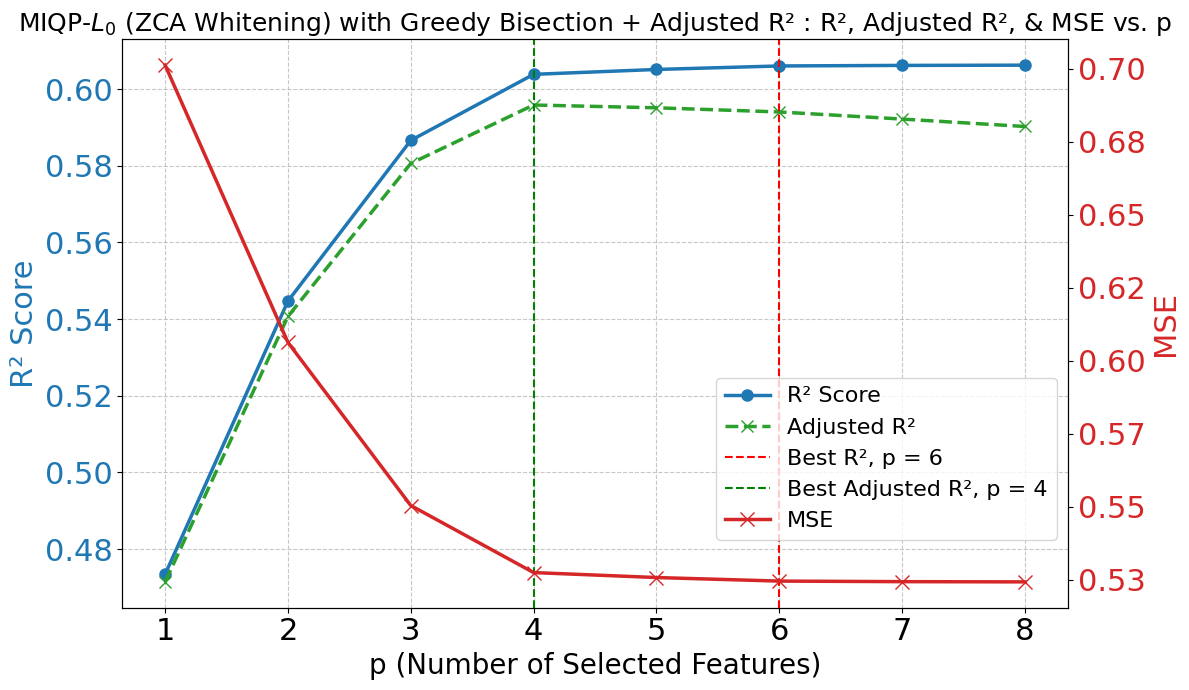

In [93]:
# Adjusted R² with penalization for number of features selected
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from gurobipy import Model, GRB, quicksum, QuadExpr

# -------------------------------
# Step 1: ZCA Whitening Function
# -------------------------------
def zca_whitening(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return X_centered @ ZCA_matrix

# -------------------------------
# Step 2: Prepare the data
# -------------------------------
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_zca = zca_whitening(X_scaled)
X_zca_df = pd.DataFrame(X_zca, columns=X.columns).reset_index(drop=True)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

X_mat = X_zca_df.values
y_vec = y_scaled
y_true = scaler_y.inverse_transform(y_vec.reshape(-1, 1)).flatten()
n, p = X_mat.shape

# -------------------------------
# Step 3: Bisection Setup
# -------------------------------
evaluated_ks = {}
bisection_eval_count = 0
track_bisection = True
M = 50

def evaluate_k(k):
    global bisection_eval_count
    if k in evaluated_ks:
        return evaluated_ks[k]
    
    if track_bisection:
        bisection_eval_count += 1

    model = Model(f"ZCA_MIP_k{k}")
    model.setParam('OutputFlag', 0)

    beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")
    z = model.addVars(p, vtype=GRB.BINARY, name="z")

    mse_expr = QuadExpr()
    for i in range(n):
        expr = quicksum(X_mat[i, j] * beta[j] for j in range(p))
        diff = y_vec[i] - expr
        mse_expr.add(diff * diff)
    mse_expr /= n
    model.setObjective(mse_expr, GRB.MINIMIZE)

    for j in range(p):
        model.addConstr(beta[j] <= M * z[j])
        model.addConstr(beta[j] >= -M * z[j])
    model.addConstr(quicksum(z[j] for j in range(p)) <= k)

    model.optimize()

    beta_vals = np.array([beta[j].X if z[j].X > 0.5 else 0 for j in range(p)])
    y_pred_scaled = X_mat @ beta_vals
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    evaluated_ks[k] = (r2, mse)
    return r2, mse

# -------------------------------
# Step 4: Bisection with Feelers
# -------------------------------
k_low, k_high = 1, p
best_k = None
best_r2 = -np.inf
feelers = 1

while k_high - k_low > 2:
    k_mid = (k_low + k_high) // 2
    r2_mid, _ = evaluate_k(k_mid)
    r2_left, _ = evaluate_k(k_mid - feelers)
    r2_right, _ = evaluate_k(k_mid + feelers)

    if r2_mid > best_r2:
        best_r2 = r2_mid
        best_k = k_mid

    if r2_left > r2_right:
        k_high = k_mid
    else:
        k_low = k_mid

print("✅ Bisection complete.")
print("Best k found:", best_k)
print("Best R²:", round(best_r2, 4))
print("Unique k values evaluated during bisection:", sorted(evaluated_ks.keys()))
print("Total MIP evaluations during bisection:", bisection_eval_count)

# -------------------------------
# Step 5: Full Evaluation with Penalized Objective
# -------------------------------
track_bisection = False
r2_scores = []
mse_scores = []
adjusted_scores = []

lambda_penalty = 0.002  # ← You can tune this

best_adjusted_score = -np.inf
best_k_adjusted = None

k_values = range(1, p + 1)

for k in k_values:
    r2, mse = evaluate_k(k)
    adjusted = r2 - lambda_penalty * k

    r2_scores.append(r2)
    mse_scores.append(mse)
    adjusted_scores.append(adjusted)

    print(f"k={k:2d} | R²={r2:.4f} | MSE={mse:.4f} | Adjusted Score={adjusted:.4f}")

    if adjusted > best_adjusted_score:
        best_adjusted_score = adjusted
        best_k_adjusted = k

print("\n🎯 Penalized selection complete.")
print("Best k (adjusted):", best_k_adjusted)
print("Best Adjusted R² - λ·k:", round(best_adjusted_score, 4))


# -------------------------------
# Step 5: Full Evaluation for Plot
# -------------------------------
track_bisection = False
r2_scores = []
mse_scores = []
k_values = range(1, p + 1)

for k in k_values:
    r2, mse = evaluate_k(k)
    r2_scores.append(r2)
    mse_scores.append(mse)
    print(f"k={k:2d} | R²={r2:.4f} | MSE={mse:.4f}")

# -------------------------------
# Step 6: Dual-Axis Plot
# -------------------------------
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax1 = plt.subplots(figsize=(12, 7))  # Bigger for presentation

# Font sizes
label_fontsize = 22
tick_fontsize = 22
title_fontsize = 18
axis_Label_fontsize = 20

# --- Left Y-axis: R² and Adjusted R² ---
color = 'tab:blue'
ax1.set_xlabel('p (Number of Selected Features)', fontsize=axis_Label_fontsize)
ax1.set_ylabel('R² Score', color=color, fontsize=label_fontsize)

# Original R²
r2_line, = ax1.plot(
    k_values, r2_scores,
    color=color, marker='o', markersize=8, linewidth=2.5,
    label='R² Score'
)

# Adjusted R²
adjusted_line, = ax1.plot(
    k_values, adjusted_scores,
    color='tab:green', marker='x', linestyle='--', markersize=8, linewidth=2.5,
    label='Adjusted R²'
)

# Mark best R²
best_r2_line = ax1.axvline(best_k, color='red', linestyle='--', label=f'Best R², p = {best_k}')
# Mark best Adjusted R²
best_adjusted_line = ax1.axvline(best_k_adjusted, color='green', linestyle='--', label=f'Best Adjusted R², p = {best_k_adjusted}')

ax1.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

# --- Right Y-axis: MSE ---
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MSE', color=color, fontsize=label_fontsize)
mse_line, = ax2.plot(
    k_values, mse_scores,
    color=color, marker='x', markersize=10, linewidth=2.5,
    label='MSE'
)
ax2.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)

# ✅ Format MSE y-axis ticks to 2 decimal places
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# --- Final layout ---
plt.title(
    'MIQP-$L_{0}$ (ZCA Whitening) with Greedy Bisection + Adjusted R² : R², Adjusted R², & MSE vs. p',
    fontsize=title_fontsize
)

ax1.grid(True, which='both', linestyle='--', alpha=0.7)
fig.tight_layout()

# ✅ Combine handles and add clear legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2,
    loc='lower right',
    bbox_to_anchor=(1, 0.10),  # (x, y) — decrease y to lower, increase y to raise
    fontsize=16,
    frameon=True
)

plt.show()



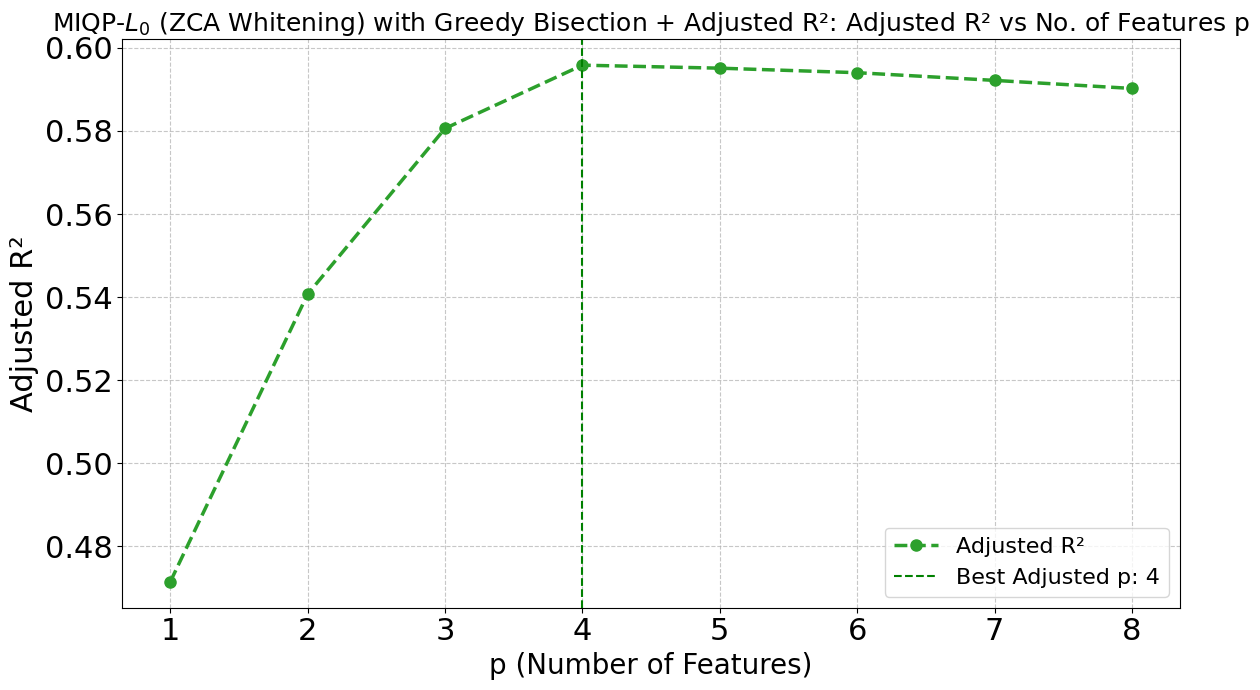

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Font sizes
label_fontsize = 22
tick_fontsize = 22
title_fontsize = 18
axis_Label_fontsize = 20

# Plot Adjusted R² with dashed line
plt.plot(
    k_values, adjusted_scores,
    color='tab:green',
    linestyle='--',       # ✅ Dashed line
    marker='o', markersize=8, linewidth=2.5,
    label='Adjusted R²'
)

# Vertical line for best Adjusted R²
plt.axvline(
    best_k_adjusted, color='green', linestyle='--',
    label=f'Best Adjusted p: {best_k_adjusted}'
)

# Labels & title
plt.xlabel('p (Number of Features)', fontsize=axis_Label_fontsize)
plt.ylabel('Adjusted R²', fontsize=label_fontsize)
plt.title('MIQP-$L_{0}$ (ZCA Whitening) with Greedy Bisection + Adjusted R²: Adjusted R² vs No. of Features p', fontsize=title_fontsize)

# Ticks & grid
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Legend
plt.legend(loc='lower right', fontsize=16, frameon=True)

plt.tight_layout()
plt.show()


Optimal Lasso model selected 8 features.
R² Score at optimal k = 0.6061
MSE at optimal k = 0.5245


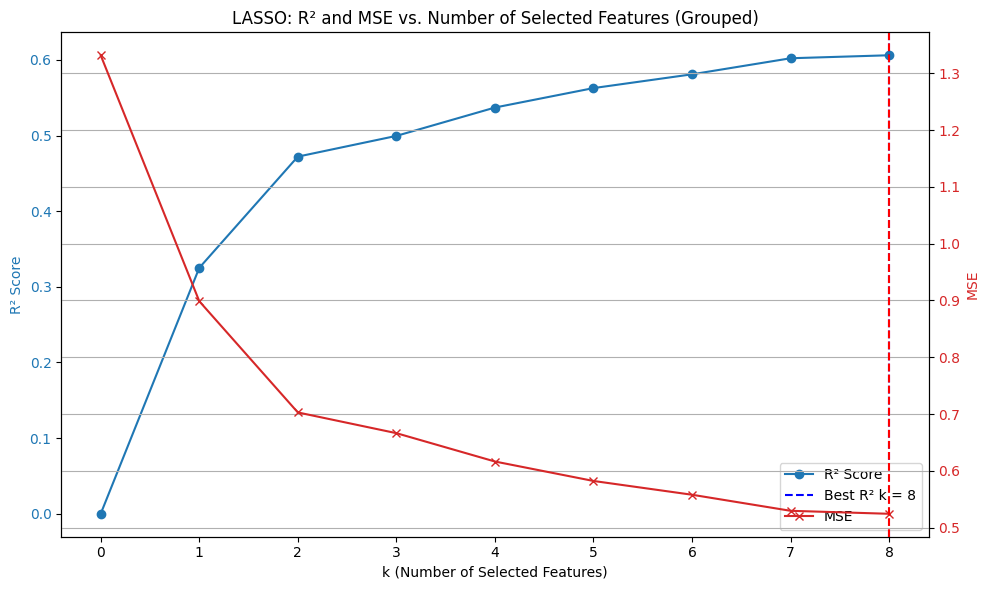

In [20]:
# Lasso Without Whitening
from sklearn.linear_model import LassoCV, Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# -------------------------------
# Fit LassoCV
# -------------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y_scaled)

# -------------------------------
# Manual evaluation across alphas
# -------------------------------
alphas = lasso.alphas_
k_list = []
r2_list = []
mse_list = []

for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000).fit(X_scaled, y_scaled)
    y_pred_scaled = model.predict(X_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    k = np.sum(model.coef_ != 0)

    k_list.append(k)
    r2_list.append(r2)
    mse_list.append(mse)

# -------------------------------
# Group by unique k values
# -------------------------------
lasso_df = pd.DataFrame({
    'k': k_list,
    'r2': r2_list,
    'mse': mse_list
})
lasso_grouped = lasso_df.groupby('k').mean().reset_index()

# -------------------------------
# Get optimal k from LassoCV model
# -------------------------------
optimal_k = np.sum(lasso.coef_ != 0)

# -------------------------------
# Print R² and MSE at optimal k
# -------------------------------
optimal_row = lasso_grouped[lasso_grouped['k'] == optimal_k]

if not optimal_row.empty:
    optimal_r2 = optimal_row['r2'].values[0]
    optimal_mse = optimal_row['mse'].values[0]
    print(f"Optimal Lasso model selected {optimal_k} features.")
    print(f"R² Score at optimal k = {optimal_r2:.4f}")
    print(f"MSE at optimal k = {optimal_mse:.4f}")
else:
    print(f"No exact match for k = {optimal_k} in grouped data.")


# -------------------------------
# Double-axis plot
# -------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left Y-axis: R²
color = 'tab:blue'
ax1.set_xlabel('k (Number of Selected Features)')
ax1.set_ylabel('R² Score', color=color)
ax1.plot(lasso_grouped['k'], lasso_grouped['r2'], color=color, marker='o', label='R² Score')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(optimal_k, color='blue', linestyle='--', label=f'Best R² k = {optimal_k}')

# Right Y-axis: MSE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MSE', color=color)
ax2.plot(lasso_grouped['k'], lasso_grouped['mse'], color=color, marker='x', label='MSE')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axvline(optimal_k, color='red', linestyle='--')

# Title and layout
plt.title('LASSO: R² and MSE vs. Number of Selected Features (Grouped)')
fig.tight_layout()
plt.grid(True)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.show()


📊 LASSO (With ZCA Whitening)
Selected features: 6
MSE: 0.5259
R²: 0.605
Optimal alpha: 0.012892


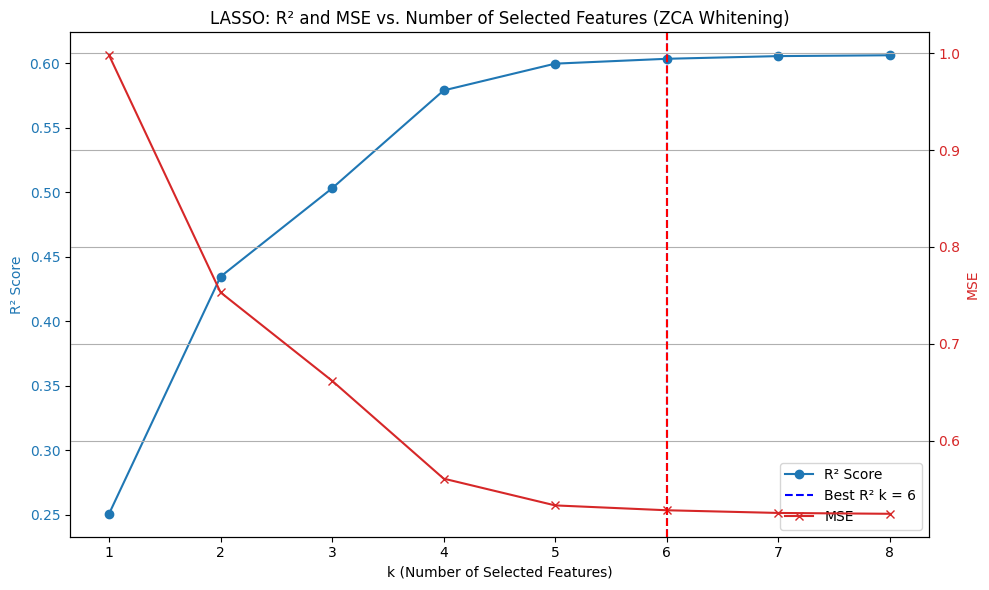

In [ ]:
# Lasso with ZCA Whitening
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------
# ZCA Whitening Function
# -------------------------------
def zca_whitening(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return X_centered @ ZCA_matrix

# -------------------------------
# Prepare Data
# -------------------------------
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal'].reset_index(drop=True)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_zca = zca_whitening(X_scaled)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# -------------------------------
# LassoCV on ZCA-whitened data
# -------------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_zca, y_scaled)

# Prediction
y_pred_scaled = lasso.predict(X_zca)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluation
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
optimal_k = np.sum(lasso.coef_ != 0)

print("📊 LASSO (With ZCA Whitening)")
print("Selected features:", optimal_k)
print("MSE:", round(mse, 4))
print("R²:", round(r2, 4))
print("Optimal alpha:", round(lasso.alpha_, 6))

# -------------------------------
# Manual Evaluation Across Alphas
# -------------------------------
alphas = lasso.alphas_
k_list, r2_list, mse_list = [], [], []

for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000).fit(X_zca, y_scaled)
    y_pred_scaled = model.predict(X_zca)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    k = np.sum(model.coef_ != 0)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)

    k_list.append(k)
    r2_list.append(r2)
    mse_list.append(mse)

# Group by unique k values
lasso_df = pd.DataFrame({'k': k_list, 'r2': r2_list, 'mse': mse_list})
lasso_grouped = lasso_df.groupby('k').mean().reset_index()

# -------------------------------
# Double-Axis Plot
# -------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left: R²
color = 'tab:blue'
ax1.set_xlabel('k (Number of Selected Features)')
ax1.set_ylabel('R² Score', color=color)
ax1.plot(lasso_grouped['k'], lasso_grouped['r2'], color=color, marker='o', label='R² Score')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(optimal_k, color='blue', linestyle='--', label=f'Best R² k = {optimal_k}')

# Right: MSE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MSE', color=color)
ax2.plot(lasso_grouped['k'], lasso_grouped['mse'], color=color, marker='x', label='MSE')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axvline(optimal_k, color='red', linestyle='--')

# Final layout
plt.title('LASSO: R² and MSE vs. Number of Selected Features (ZCA Whitening)')
fig.tight_layout()
plt.grid(True)

# Combined legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.show()


Saved to: d:\FAU\Modelling-Seminar-Data-Science


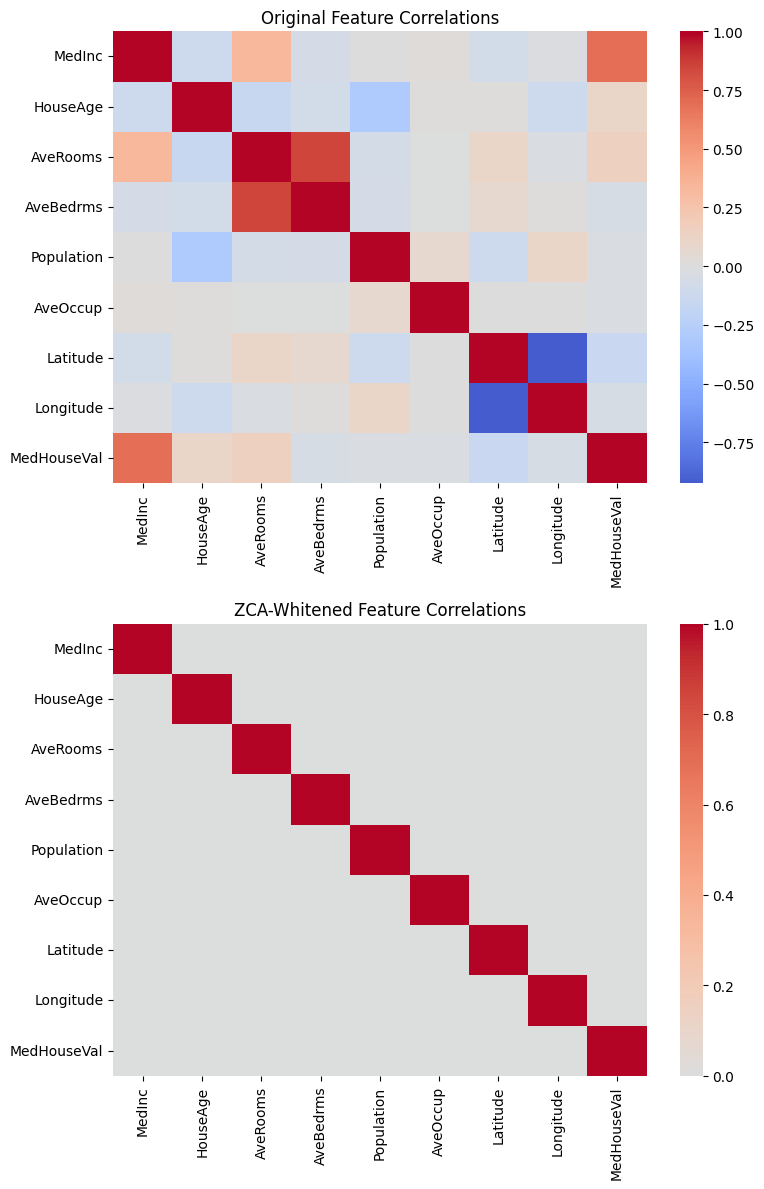

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

# Load dataset
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# ZCA Whitening
def zca_whitening(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    U, S, _ = np.linalg.svd(cov)
    epsilon = 1e-5
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return X_centered @ ZCA_matrix

X_zca = zca_whitening(X_scaled)

# Create vertically stacked heatmaps
fig, axs = plt.subplots(2, 1, figsize=(8, 12))  # Two rows, one column

sns.heatmap(pd.DataFrame(X_scaled, columns=df.columns).corr(), ax=axs[0], cmap='coolwarm', center=0)
axs[0].set_title('Original Feature Correlations')

sns.heatmap(pd.DataFrame(X_zca, columns=df.columns).corr(), ax=axs[1], cmap='coolwarm', center=0)
axs[1].set_title('ZCA-Whitened Feature Correlations')

plt.tight_layout()
import os
print("Saved to:", os.getcwd())

plt.savefig("D:\FAU\Modelling-Seminar-Data-Science/zca_correlation_heatmaps.png", dpi=1200, bbox_inches='tight')

plt.show()
